In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

In [14]:
import run_sampler, models

In [4]:
MH_pop = 112374333
start_date = datetime.datetime(2021, 1, 1)

In [5]:
analysis = run_sampler.tuning_exp(
    "Maharashtra",
    MH_pop,
    start_date=start_date
)

2021-05-05 18:26:25,285	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265
2021-05-05 18:26:27,131	WARNING function_runner.py:544 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho
_tuning_fn_a3fa4_00000,RUNNING,,0.987849,0.267392,0.0496398,0.592425,0.0334195,0.692719,0.000303134
_tuning_fn_a3fa4_00001,PENDING,,0.873924,0.165736,0.0141921,0.460824,0.0337693,0.512459,0.000951771
_tuning_fn_a3fa4_00002,PENDING,,1.00628,0.281291,0.0277342,0.505213,0.0314493,0.563634,0.000156348
_tuning_fn_a3fa4_00003,PENDING,,1.14535,0.238374,0.0230085,0.3713,0.0236163,0.789493,0.00067308
_tuning_fn_a3fa4_00004,PENDING,,1.14134,0.155127,0.0465871,0.660419,0.0298113,0.534037,0.000185432
_tuning_fn_a3fa4_00005,PENDING,,0.838603,0.0833653,0.0204425,0.657211,0.0490642,0.301035,0.000201456
_tuning_fn_a3fa4_00006,PENDING,,1.07426,0.328555,0.0425925,0.405882,0.024722,0.635797,0.000207079
_tuning_fn_a3fa4_00007,PENDING,,1.05934,0.181679,0.0105793,0.371692,0.0352026,0.302494,0.000483806
_tuning_fn_a3fa4_00008,PENDING,,1.11794,0.202264,0.023427,0.652629,0.0427933,0.716372,0.00066568
_tuning_fn_a3fa4_00009,PENDING,,0.873085,0.315914,0.0252573,0.465316,0.0159973,0.603268,0.000272213


Result for _tuning_fn_a3fa4_00000:
  date: 2021-05-05_18-26-29
  done: false
  experiment_id: 669f657875ef460f98f0a3014d831330
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1859403383892118
  node_ip: 192.168.192.62
  pid: 5593
  time_since_restore: 0.07494902610778809
  time_this_iter_s: 0.07494902610778809
  time_total_s: 0.07494902610778809
  timestamp: 1620231989
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00000
  
Result for _tuning_fn_a3fa4_00000:
  date: 2021-05-05_18-26-29
  done: true
  experiment_id: 669f657875ef460f98f0a3014d831330
  experiment_tag: 0_beta=0.98785,eps=0.26739,mu=0.04964,p_a=0.59242,p_d=0.033419,r_b=0.69272,rho=0.00030313
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1859403383892118
  node_ip: 192.168.192.62
  pid: 5593
  time_since_restore: 0.07494902610778809
  time_this_iter_s: 0.07494902610778809
  time_total_s: 0.07494902610778809
  timestamp: 1620231989
  tim

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_a3fa4_00008,RUNNING,,1.11794,0.202264,0.023427,0.652629,0.0427933,0.716372,0.00066568,,,
_tuning_fn_a3fa4_00009,RUNNING,,0.873085,0.315914,0.0252573,0.465316,0.0159973,0.603268,0.000272213,,,
_tuning_fn_a3fa4_00010,RUNNING,,1.09836,0.12778,0.0261167,0.486328,0.0202698,0.471619,0.000954788,,,
_tuning_fn_a3fa4_00011,RUNNING,,0.759174,0.175992,0.0268269,0.43198,0.046341,0.533658,0.000471345,,,
_tuning_fn_a3fa4_00012,RUNNING,,0.796918,0.0698611,0.0151893,0.316186,0.0325737,0.748686,0.000132489,,,
_tuning_fn_a3fa4_00013,RUNNING,,1.05763,0.0775057,0.0382385,0.630708,0.0210525,0.692336,0.000177351,,,
_tuning_fn_a3fa4_00014,RUNNING,,1.16527,0.0758395,0.0353148,0.460076,0.0105413,0.554161,0.000678209,,,
_tuning_fn_a3fa4_00016,PENDING,,0.792109,0.209437,0.0311055,0.366192,0.0467784,0.771202,0.000824986,,,
_tuning_fn_a3fa4_00017,PENDING,,1.0801,0.256259,0.0159533,0.536616,0.0354146,0.798591,0.000445207,,,
_tuning_fn_a3fa4_00018,PENDING,,1.03539,0.279373,0.0479896,0.35505,0.0349827,0.6211,0.000115349,,,


Result for _tuning_fn_a3fa4_00015:
  date: 2021-05-05_18-26-35
  done: false
  experiment_id: c05622d0c92b4f858f4128e7f117338a
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1835950455139117
  node_ip: 192.168.192.62
  pid: 5614
  time_since_restore: 0.09080100059509277
  time_this_iter_s: 0.09080100059509277
  time_total_s: 0.09080100059509277
  timestamp: 1620231995
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00015
  
Result for _tuning_fn_a3fa4_00015:
  date: 2021-05-05_18-26-35
  done: true
  experiment_id: c05622d0c92b4f858f4128e7f117338a
  experiment_tag: 15_beta=1.0168,eps=0.28263,mu=0.015067,p_a=0.60659,p_d=0.016893,r_b=0.59314,rho=0.00063554
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1835950455139117
  node_ip: 192.168.192.62
  pid: 5614
  time_since_restore: 0.09080100059509277
  time_this_iter_s: 0.09080100059509277
  time_total_s: 0.09080100059509277
  timestamp: 1620231995
  ti

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_a3fa4_00016,RUNNING,,0.792109,0.209437,0.0311055,0.366192,0.0467784,0.771202,0.000824986,,,
_tuning_fn_a3fa4_00017,RUNNING,,1.0801,0.256259,0.0159533,0.536616,0.0354146,0.798591,0.000445207,,,
_tuning_fn_a3fa4_00018,RUNNING,,1.03539,0.279373,0.0479896,0.35505,0.0349827,0.6211,0.000115349,,,
_tuning_fn_a3fa4_00019,RUNNING,,1.0866,0.236546,0.0399502,0.659404,0.0262979,0.503398,0.000360531,,,
_tuning_fn_a3fa4_00020,RUNNING,,0.897081,0.326915,0.0160851,0.366246,0.0456888,0.749959,0.00059296,,,
_tuning_fn_a3fa4_00021,RUNNING,,0.99079,0.294609,0.0245427,0.638663,0.0459277,0.560574,0.000199654,,,
_tuning_fn_a3fa4_00022,RUNNING,192.168.192.62:5656,0.80971,0.312855,0.0209697,0.629824,0.0450914,0.723491,0.000171905,1,0.0915411,3.1684
_tuning_fn_a3fa4_00024,PENDING,,1.03923,0.276034,0.0142507,0.579911,0.0457397,0.433639,0.000354715,,,
_tuning_fn_a3fa4_00025,PENDING,,0.994048,0.0812951,0.0140685,0.486859,0.0285933,0.32962,0.000596856,,,
_tuning_fn_a3fa4_00026,PENDING,,0.76476,0.102499,0.039676,0.603892,0.0386336,0.43624,0.000205513,,,


Result for _tuning_fn_a3fa4_00016:
  date: 2021-05-05_18-26-41
  done: false
  experiment_id: 429e59ef832d4f10bdb99af51df3cc65
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.0495410669334855
  node_ip: 192.168.192.62
  pid: 5659
  time_since_restore: 0.08483028411865234
  time_this_iter_s: 0.08483028411865234
  time_total_s: 0.08483028411865234
  timestamp: 1620232001
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00016
  
Result for _tuning_fn_a3fa4_00018:
  date: 2021-05-05_18-26-41
  done: false
  experiment_id: 8004438b486b42eea381fd247499b3ff
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.2661250404675437
  node_ip: 192.168.192.62
  pid: 5658
  time_since_restore: 0.08274316787719727
  time_this_iter_s: 0.08274316787719727
  time_total_s: 0.08274316787719727
  timestamp: 1620232001
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00018
  
Result for _tuning_fn_a3fa4_0001

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_a3fa4_00024,RUNNING,,1.03923,0.276034,0.0142507,0.579911,0.0457397,0.433639,0.000354715,,,
_tuning_fn_a3fa4_00025,RUNNING,,0.994048,0.0812951,0.0140685,0.486859,0.0285933,0.32962,0.000596856,,,
_tuning_fn_a3fa4_00026,RUNNING,,0.76476,0.102499,0.039676,0.603892,0.0386336,0.43624,0.000205513,,,
_tuning_fn_a3fa4_00027,RUNNING,,0.913435,0.300484,0.0444835,0.33803,0.0245412,0.670227,0.000102998,,,
_tuning_fn_a3fa4_00028,RUNNING,,1.08123,0.212136,0.0207134,0.463846,0.0272113,0.710064,0.000361,,,
_tuning_fn_a3fa4_00029,RUNNING,192.168.192.62:5684,1.11659,0.1678,0.0209514,0.522541,0.0110408,0.438764,0.000300649,1,0.0978701,2.97926
_tuning_fn_a3fa4_00030,RUNNING,,1.11972,0.239769,0.0439687,0.642707,0.0300751,0.76811,0.000197198,,,
_tuning_fn_a3fa4_00032,PENDING,,1.12938,0.311515,0.0141313,0.584068,0.0195462,0.767795,0.000141345,,,
_tuning_fn_a3fa4_00033,PENDING,,0.860092,0.278587,0.0421227,0.600431,0.0319062,0.306804,0.000910997,,,
_tuning_fn_a3fa4_00034,PENDING,,1.16244,0.199442,0.030012,0.523665,0.0166503,0.546577,0.000161544,,,


Result for _tuning_fn_a3fa4_00029:
  date: 2021-05-05_18-26-46
  done: true
  experiment_id: 10c90a2703a64bcd9ccab66bf0e71801
  experiment_tag: 29_beta=1.1166,eps=0.1678,mu=0.020951,p_a=0.52254,p_d=0.011041,r_b=0.43876,rho=0.00030065
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.979261439199727
  node_ip: 192.168.192.62
  pid: 5684
  time_since_restore: 0.0978701114654541
  time_this_iter_s: 0.0978701114654541
  time_total_s: 0.0978701114654541
  timestamp: 1620232006
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00029
  
Result for _tuning_fn_a3fa4_00028:
  date: 2021-05-05_18-26-46
  done: false
  experiment_id: 0375c30afbae44eb8d2c6a370fe66e6c
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.18068341543985
  node_ip: 192.168.192.62
  pid: 5689
  time_since_restore: 0.09444785118103027
  time_this_iter_s: 0.09444785118103027
  time_total_s: 0.09444785118103027
  timestamp: 1620232006
  timesteps

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_a3fa4_00032,RUNNING,,1.12938,0.311515,0.0141313,0.584068,0.0195462,0.767795,0.000141345,,,
_tuning_fn_a3fa4_00033,RUNNING,,0.860092,0.278587,0.0421227,0.600431,0.0319062,0.306804,0.000910997,,,
_tuning_fn_a3fa4_00034,RUNNING,,1.16244,0.199442,0.030012,0.523665,0.0166503,0.546577,0.000161544,,,
_tuning_fn_a3fa4_00035,RUNNING,,1.07491,0.149392,0.0214645,0.428433,0.0479626,0.464789,0.000513736,,,
_tuning_fn_a3fa4_00036,RUNNING,,0.907495,0.205841,0.027819,0.533166,0.0397689,0.534965,0.000161799,,,
_tuning_fn_a3fa4_00037,RUNNING,192.168.192.62:5714,1.03428,0.268525,0.0468857,0.582107,0.0226112,0.592719,0.000228934,1,0.102219,3.17225
_tuning_fn_a3fa4_00038,RUNNING,,0.942646,0.240288,0.0410496,0.532053,0.0478945,0.617025,0.000675063,,,
_tuning_fn_a3fa4_00040,PENDING,,1.07822,0.283005,0.0166393,0.359973,0.0455073,0.505936,0.00027446,,,
_tuning_fn_a3fa4_00041,PENDING,,1.03882,0.317338,0.0444666,0.693049,0.0165605,0.490134,0.000390597,,,
_tuning_fn_a3fa4_00042,PENDING,,0.8291,0.300892,0.0374002,0.252601,0.0176597,0.690629,0.000286289,,,


Result for _tuning_fn_a3fa4_00034:
  date: 2021-05-05_18-26-52
  done: false
  experiment_id: 0b910cbb819f478ab7595eecdd8666f4
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1238629708851624
  node_ip: 192.168.192.62
  pid: 5718
  time_since_restore: 0.09156394004821777
  time_this_iter_s: 0.09156394004821777
  time_total_s: 0.09156394004821777
  timestamp: 1620232012
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00034
  
Result for _tuning_fn_a3fa4_00038:
  date: 2021-05-05_18-26-52
  done: false
  experiment_id: 4eebf3a44be84e91ad0e3ecf1686cb08
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1180886152303757
  node_ip: 192.168.192.62
  pid: 5713
  time_since_restore: 0.09890317916870117
  time_this_iter_s: 0.09890317916870117
  time_total_s: 0.09890317916870117
  timestamp: 1620232012
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00038
  
Result for _tuning_fn_a3fa4_0003

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_a3fa4_00040,RUNNING,,1.07822,0.283005,0.0166393,0.359973,0.0455073,0.505936,0.00027446,,,
_tuning_fn_a3fa4_00041,RUNNING,,1.03882,0.317338,0.0444666,0.693049,0.0165605,0.490134,0.000390597,,,
_tuning_fn_a3fa4_00042,RUNNING,,0.8291,0.300892,0.0374002,0.252601,0.0176597,0.690629,0.000286289,,,
_tuning_fn_a3fa4_00043,RUNNING,,0.869016,0.188134,0.0424461,0.320601,0.0279204,0.460899,0.000924848,,,
_tuning_fn_a3fa4_00044,RUNNING,,1.03937,0.272723,0.0252328,0.457957,0.0263027,0.478791,0.000183529,,,
_tuning_fn_a3fa4_00045,RUNNING,,0.982597,0.117052,0.0484134,0.477912,0.0484578,0.327191,0.000254697,,,
_tuning_fn_a3fa4_00046,RUNNING,192.168.192.62:5746,1.04704,0.299323,0.0480436,0.587485,0.0493131,0.603425,0.000755075,1,0.103029,3.22896
_tuning_fn_a3fa4_00047,RUNNING,,0.913309,0.25717,0.0176868,0.34513,0.048839,0.422116,0.000236751,,,
_tuning_fn_a3fa4_00048,PENDING,,0.992893,0.208761,0.0169465,0.452529,0.0316214,0.582292,0.000429396,,,
_tuning_fn_a3fa4_00049,PENDING,,1.07199,0.207921,0.0285512,0.388281,0.0349094,0.461089,0.000466124,,,


Result for _tuning_fn_a3fa4_00044:
  date: 2021-05-05_18-26-59
  done: false
  experiment_id: 65dbc8ec7a1d49b78da63041a2aa6d86
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.1921103978756356
  node_ip: 192.168.192.62
  pid: 5747
  time_since_restore: 0.10328006744384766
  time_this_iter_s: 0.10328006744384766
  time_total_s: 0.10328006744384766
  timestamp: 1620232019
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00044
  
Result for _tuning_fn_a3fa4_00047:
  date: 2021-05-05_18-26-59
  done: false
  experiment_id: c8c4b76815a8489eb08c98c14b3b1c5f
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 3.131003810143333
  node_ip: 192.168.192.62
  pid: 5744
  time_since_restore: 0.0982820987701416
  time_this_iter_s: 0.0982820987701416
  time_total_s: 0.0982820987701416
  timestamp: 1620232019
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a3fa4_00047
  
Result for _tuning_fn_a3fa4_00044:
 

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_a3fa4_00000,TERMINATED,,0.987849,0.267392,0.0496398,0.592425,0.0334195,0.692719,0.000303134,1,0.074949,3.18594
_tuning_fn_a3fa4_00001,TERMINATED,,0.873924,0.165736,0.0141921,0.460824,0.0337693,0.512459,0.000951771,1,0.0876589,2.88068
_tuning_fn_a3fa4_00002,TERMINATED,,1.00628,0.281291,0.0277342,0.505213,0.0314493,0.563634,0.000156348,1,0.115298,3.20814
_tuning_fn_a3fa4_00003,TERMINATED,,1.14535,0.238374,0.0230085,0.3713,0.0236163,0.789493,0.00067308,1,0.0788443,3.27299
_tuning_fn_a3fa4_00004,TERMINATED,,1.14134,0.155127,0.0465871,0.660419,0.0298113,0.534037,0.000185432,1,0.0730052,2.94076
_tuning_fn_a3fa4_00005,TERMINATED,,0.838603,0.0833653,0.0204425,0.657211,0.0490642,0.301035,0.000201456,1,0.0702648,2.1257
_tuning_fn_a3fa4_00006,TERMINATED,,1.07426,0.328555,0.0425925,0.405882,0.024722,0.635797,0.000207079,1,0.101807,3.31793
_tuning_fn_a3fa4_00007,TERMINATED,,1.05934,0.181679,0.0105793,0.371692,0.0352026,0.302494,0.000483806,1,0.0863113,2.99111
_tuning_fn_a3fa4_00008,TERMINATED,,1.11794,0.202264,0.023427,0.652629,0.0427933,0.716372,0.00066568,1,0.118514,3.15794
_tuning_fn_a3fa4_00009,TERMINATED,,0.873085,0.315914,0.0252573,0.465316,0.0159973,0.603268,0.000272213,1,0.120677,3.17744


2021-05-05 18:27:02,965	INFO tune.py:549 -- Total run time: 35.84 seconds (35.59 seconds for the tuning loop).
Best config:  {'beta': 0.8386029500652245, 'p_a': 0.657211469050981, 'r_b': 0.30103487183046806, 'eps': 0.08336532587897881, 'mu': 0.020442516796119234, 'rho': 0.00020145623606869248, 'p_d': 0.04906415625843857}


array([[<AxesSubplot:title={'center':'kl_div'}>]], dtype=object)

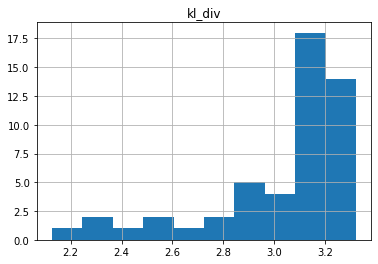

In [10]:
analysis.results_df.hist("kl_div")

In [15]:
model = models.seiird(**analysis.best_result["config"])